In [161]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect

from apoNN.src.occam import Occam

import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections


from apoNN.src.datasets import ApogeeDataset,AspcapDataset

from apoNN.src.utils import generate_loss_with_masking
from apoNN.src.utils import dump
from apoNN.src.utils import load
import apoNN.src.vectors as vector

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
allStar =  load("allStar_training_restricted")
dataset=  AspcapDataset(filename="aspcap_restricted",tensor_type=torch.FloatTensor,recenter=True)
n_data=10000

We discard those spectra without measured abundances

In [163]:
upper_temp_cut = allStar["Teff"]<7000
lower_temp_cut = allStar["Teff"]>3500
lower_g_cut = allStar["logg"]>1.
upper_g_cut = allStar["logg"]<3.5
snr_cut = allStar["SNR"]>100
snr_highcut = allStar["SNR"]<500
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5



combined_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut & snr_cut & snr_highcut & feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut

In [164]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/aspcap/dim/z5b/ae_7000.p")
#autoencoder.intermediate_activation=None

small test that we are indeed correctly reconstructing spectra

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


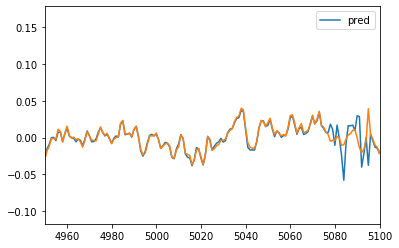

In [170]:
x = torch.tensor(dataset[1][0].unsqueeze(0).to(device))
x_pred,z_test = autoencoder(x)
plt.plot(x_pred[0].detach().cpu().numpy(),label="pred")
plt.plot(x[0].detach().cpu().numpy())
#plt.plot(dataset[1][2])

plt.xlim(4950,5100)
plt.legend()

### Creating full dataset vectors

In [143]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE"] 
y = vector.Vector(np.array([allStar[:n_data][combined_cut[:n_data]][param] for param in considered_parameters])[:,:n_data].T)

In [144]:
z = vector.LatentVector(dataset,autoencoder,n_data)
z = vector.Vector(z.raw[combined_cut[:n_data]])

/share/splinter/ddm/taggingProject/apogeeFactory/apoNN/src/vectors.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _,z = self.autoencoder(torch.tensor(self.dataset[idx][0]).to(device).unsqueeze(0))


In [145]:
w = vector.LinearTransformation(z,y)
nonlinear_w = vector.NonLinearTransformation(z,y)
nonlinear_w.fit(n_epochs=200)

err:0.09577741473913193
err:0.08977019041776657
err:0.07369916141033173
err:0.07776441425085068
err:0.06500975787639618
err:0.05276830121874809
err:0.043699417263269424
err:0.03679700940847397
err:0.031803082674741745
err:0.035301126539707184
err:0.025978103280067444
err:0.022772647440433502
err:0.025449277833104134
err:0.017639342695474625
err:0.024376971647143364
err:0.01826532557606697
err:0.01497703231871128
err:0.01584877260029316
err:0.013520012609660625
err:0.015637176111340523
err:0.014048636890947819
err:0.015924803912639618
err:0.015408716164529324
err:0.015463031828403473
err:0.013769518584012985
err:0.014223828911781311
err:0.014720282517373562
err:0.01384254451841116
err:0.01482068095356226
err:0.017562609165906906
err:0.019584674388170242
err:0.025697464123368263
err:0.01777220517396927
err:0.027616845443844795
err:0.01941143348813057
err:0.01769738271832466
err:0.01726199872791767
err:0.010435730218887329
err:0.014591135084629059
err:0.011009350419044495
err:0.0140093378

err:0.009828603826463223
err:0.010816996917128563
err:0.011546267196536064
err:0.009989847429096699
err:0.011615173891186714
err:0.01029055006802082
err:0.012512817978858948
err:0.013052458874881268
err:0.009754498489201069
err:0.0078624552115798
err:0.009584003128111362
err:0.016395622864365578
err:0.008963791653513908
err:0.011162233538925648
err:0.011410260573029518
err:0.011937747709453106
err:0.010863935574889183
err:0.011856785975396633
err:0.011278718709945679
err:0.010583591647446156
err:0.010390350595116615
err:0.011446433141827583
err:0.01053125225007534
err:0.010210283100605011
err:0.012869711965322495
err:0.009151598438620567
err:0.010649572126567364
err:0.01008827518671751
err:0.009608766064047813
err:0.009212508797645569
err:0.0076165469363331795
err:0.010117395780980587
err:0.009312579408288002
err:0.010121077299118042
err:0.011579766869544983
err:0.01037849672138691
err:0.008410599082708359
err:0.009187821298837662
err:0.009856644086539745
err:0.00863103661686182
err:0.

err:0.011531773023307323
err:0.011245176196098328
err:0.010727260261774063
err:0.014201328158378601
err:0.01055582519620657
err:0.009865235537290573
err:0.007109521422535181
err:0.009056918323040009
err:0.007525361608713865
err:0.011112024076282978
err:0.008523721247911453
err:0.008886790834367275
err:0.010050224140286446
err:0.010861417278647423
err:0.009334581904113293
err:0.010807479731738567
err:0.009722910821437836
err:0.011612387374043465
err:0.012329324148595333
err:0.00901582557708025
err:0.007116612046957016
err:0.008692696690559387
err:0.01516389288008213
err:0.00841958075761795
err:0.010092458687722683
err:0.010665666311979294
err:0.011012573726475239
err:0.00989465694874525
err:0.010862135328352451
err:0.010715045034885406
err:0.010066214948892593
err:0.009586385451257229
err:0.010717317461967468
err:0.0099104642868042
err:0.009752077050507069
err:0.012201005592942238
err:0.0084900027140975
err:0.00980024691671133
err:0.009385304525494576
err:0.008908587507903576
err:0.0086

err:0.015246639959514141
err:0.014461793005466461
err:0.013841845095157623
err:0.014000924304127693
err:0.008342180401086807
err:0.010794274508953094
err:0.008391947485506535
err:0.00891230907291174
err:0.008503693155944347
err:0.011332680471241474
err:0.008893733844161034
err:0.008275477215647697
err:0.012717554345726967
err:0.009185045957565308
err:0.008084156550467014
err:0.011492308229207993
err:0.011832269839942455
err:0.01100924238562584
err:0.010761400684714317
err:0.010389911942183971
err:0.013585364446043968
err:0.01012941263616085
err:0.009324982762336731
err:0.006754833273589611
err:0.008565783500671387
err:0.007171317003667355
err:0.010617471300065517
err:0.008161053992807865
err:0.008425790816545486
err:0.009587780572474003
err:0.010432396084070206
err:0.009000814519822598
err:0.010415571741759777
err:0.009406140074133873
err:0.01101746130734682
err:0.01186661422252655
err:0.008614418096840382
err:0.006720290519297123
err:0.008187295868992805
err:0.014561234042048454
err:0

err:0.00913318432867527
err:0.01033690944314003
err:0.009212614968419075
err:0.007694333791732788
err:0.0077924588695168495
err:0.00852781068533659
err:0.0074928379617631435
err:0.009458010084927082
err:0.009062722325325012
err:0.011306132189929485
err:0.012669309042394161
err:0.01110281702131033
err:0.014596736058592796
err:0.014156273566186428
err:0.013537575490772724
err:0.01350513193756342
err:0.008085875771939754
err:0.01051450427621603
err:0.008163005113601685
err:0.008571572601795197
err:0.00825643539428711
err:0.01095149852335453
err:0.008614190854132175
err:0.008028768002986908
err:0.012125886976718903
err:0.008751165121793747
err:0.007749284151941538
err:0.011106714606285095
err:0.011312396265566349
err:0.010705050081014633
err:0.010470039211213589
err:0.010150122456252575
err:0.013193055056035519
err:0.00982790719717741
err:0.008952518925070763
err:0.00654039578512311
err:0.008247037418186665
err:0.006958331447094679
err:0.010260779410600662
err:0.007901458069682121
err:0.00

err:0.00931067205965519
err:0.009229038842022419
err:0.0115503603592515
err:0.007765680551528931
err:0.009095408953726292
err:0.008654994890093803
err:0.008266787976026535
err:0.008075930178165436
err:0.006625785958021879
err:0.009110786020755768
err:0.00795027706772089
err:0.008981425315141678
err:0.01013046782463789
err:0.009015271440148354
err:0.007597567513585091
err:0.007588470354676247
err:0.008357962593436241
err:0.007327388506382704
err:0.009242329746484756
err:0.0087883360683918
err:0.01096024364233017
err:0.012229925021529198
err:0.010815390385687351
err:0.014198233373463154
err:0.013908356428146362
err:0.01334453746676445
err:0.013133896514773369
err:0.007916178554296494
err:0.010335179977118969
err:0.0079735666513443
err:0.008319555781781673
err:0.008093037642538548
err:0.01066565327346325
err:0.008386090397834778
err:0.007869807071983814
err:0.011717206798493862
err:0.008486529812216759
err:0.0075305430218577385
err:0.010865753516554832
err:0.010977936908602715
err:0.01049

err:0.013842546381056309
err:0.00781101081520319
err:0.008872834034264088
err:0.009725239127874374
err:0.010070636868476868
err:0.008673369884490967
err:0.009592701680958271
err:0.009807699359953403
err:0.009344839490950108
err:0.008593138307332993
err:0.009814372286200523
err:0.009221524000167847
err:0.009129280224442482
err:0.011444004252552986
err:0.007617223542183638
err:0.00895158015191555
err:0.008508951403200626
err:0.008135606534779072
err:0.007982942275702953
err:0.006529351230710745
err:0.009018264710903168
err:0.007807204034179449
err:0.008845004253089428
err:0.00996118038892746
err:0.008850998245179653
err:0.007515554782003164
err:0.007421952206641436
err:0.008238709531724453
err:0.007211313582956791
err:0.009083778597414494
err:0.008593837730586529
err:0.010715720243752003
err:0.011901970952749252
err:0.010594328865408897
err:0.013917718082666397
err:0.01370320376008749
err:0.013212810270488262
err:0.012849564664065838
err:0.007785134483128786
err:0.010169846937060356
err:

err:0.0074944146908819675
err:0.007716962601989508
err:0.008765227161347866
err:0.009583916515111923
err:0.00837835855782032
err:0.009684166871011257
err:0.008708139881491661
err:0.009886874817311764
err:0.01104215532541275
err:0.007790703792124987
err:0.0060414657928049564
err:0.007313134148716927
err:0.013739682734012604
err:0.007744577247649431
err:0.008741733618080616
err:0.009588965214788914
err:0.009956100955605507
err:0.008512438274919987
err:0.009435868822038174
err:0.009671895764768124
err:0.009234565310180187
err:0.008463478647172451
err:0.009673834778368473
err:0.00915028341114521
err:0.009047736413776875
err:0.01137696485966444
err:0.007497290149331093
err:0.00884055346250534
err:0.008387934416532516
err:0.00803373847156763
err:0.007898008450865746
err:0.006456997711211443
err:0.008936154656112194
err:0.0076876976527273655
err:0.008722586557269096
err:0.009846195578575134
err:0.00872525479644537
err:0.00745860580354929
err:0.0072922296822071075
err:0.00814972072839737
err:0

err:0.010492339730262756
err:0.010093853808939457
err:0.009933657012879848
err:0.009668064303696156
err:0.012555847875773907
err:0.009234004653990269
err:0.008262120187282562
err:0.006168021354824305
err:0.00764057319611311
err:0.00661065336316824
err:0.009588652290403843
err:0.0074243927374482155
err:0.007633124478161335
err:0.008659662678837776
err:0.009482452645897865
err:0.008287126198410988
err:0.009577365592122078
err:0.008616629987955093
err:0.009721939451992512
err:0.01092751044780016
err:0.007677950896322727
err:0.005968455690890551
err:0.007202792447060347
err:0.01362390723079443
err:0.007690482307225466
err:0.008637151680886745
err:0.009477421641349792
err:0.009868769906461239
err:0.00840240903198719
err:0.009296657517552376
err:0.009564166888594627
err:0.009160736575722694
err:0.00836960133165121
err:0.009558682329952717
err:0.009077132679522038
err:0.008970345370471478
err:0.011314558796584606
err:0.007414800580590963
err:0.008756628260016441
err:0.00830081757158041
err:0.

err:0.012363418005406857
err:0.007543996442109346
err:0.009864347986876965
err:0.007528366521000862
err:0.007767789531499147
err:0.0076989224180579185
err:0.01000417210161686
err:0.00786218699067831
err:0.007470329757779837
err:0.010808425024151802
err:0.007966316305100918
err:0.007116983179003
err:0.010336724109947681
err:0.010402454063296318
err:0.010010925121605396
err:0.009846269153058529
err:0.009595183655619621
err:0.01243912149220705
err:0.009149942547082901
err:0.00817168690264225
err:0.006118858233094215
err:0.0075618429109454155
err:0.00657176598906517
err:0.009488660842180252
err:0.007374208886176348
err:0.0075683570466935635
err:0.008567770943045616
err:0.009399186819791794
err:0.008203275501728058
err:0.009491965174674988
err:0.008533480577170849
err:0.009584274142980576
err:0.010816502384841442
err:0.007588000502437353
err:0.005909482017159462
err:0.007111150771379471
err:0.013524580746889114
err:0.007643910590559244
err:0.008550631813704967
err:0.00938328355550766
err:0.

err:0.007302504498511553
err:0.007054179906845093
err:0.007969184778630733
err:0.006993599236011505
err:0.008738039992749691
err:0.008162972517311573
err:0.010212576016783714
err:0.011147990822792053
err:0.010065056383609772
err:0.01331076305359602
err:0.01323090773075819
err:0.012898894026875496
err:0.012260842137038708
err:0.0074792965315282345
err:0.009800526313483715
err:0.007450917735695839
err:0.007672303821891546
err:0.007624082732945681
err:0.009902476333081722
err:0.007777492515742779
err:0.007409871555864811
err:0.010664134286344051
err:0.007890011183917522
err:0.00704228738322854
err:0.010238181799650192
err:0.010330202989280224
err:0.009940446354448795
err:0.009766609407961369
err:0.009527938440442085
err:0.01233267318457365
err:0.009071762673556805
err:0.008083569817245007
err:0.006083301268517971
err:0.007496310863643885
err:0.006534830201417208
err:0.009400603361427784
err:0.007330152206122875
err:0.007511588279157877
err:0.008486052975058556
err:0.009325509890913963
err

err:0.007226006593555212
err:0.008580073714256287
err:0.008136940188705921
err:0.007777303457260132
err:0.007697656285017729
err:0.006305252201855183
err:0.008741263300180435
err:0.007428906857967377
err:0.008431332185864449
err:0.009547199122607708
err:0.008430775254964828
err:0.00726826349273324
err:0.006998715456575155
err:0.007920588366687298
err:0.0069555663503706455
err:0.008683694526553154
err:0.008089910261332989
err:0.010121473111212254
err:0.01102453749626875
err:0.00997782964259386
err:0.01320942584425211
err:0.013137451373040676
err:0.01282405573874712
err:0.012149214744567871
err:0.007424111478030682
err:0.009732261300086975
err:0.007382453419268131
err:0.007567416876554489
err:0.007557072211056948
err:0.009801073931157589
err:0.007699235342442989
err:0.007351204752922058
err:0.0105515718460083
err:0.007824843749403954
err:0.006979309022426605
err:0.010151230730116367
err:0.010268684476613998
err:0.00987621583044529
err:0.00968904234468937
err:0.009480206295847893
err:0.01

err:0.008370961993932724
err:0.009185662493109703
err:0.009650567546486855
err:0.0081019913777709
err:0.008926496841013432
err:0.00930077861994505
err:0.008964227512478828
err:0.008146030828356743
err:0.009293158538639545
err:0.008851822465658188
err:0.008778370916843414
err:0.011158942244946957
err:0.007177051156759262
err:0.008535817265510559
err:0.008100115694105625
err:0.007731472607702017
err:0.007660310249775648
err:0.006278809159994125
err:0.008702143095433712
err:0.0073811667971313
err:0.008369619026780128
err:0.009485173970460892
err:0.008372923359274864
err:0.0072341188788414
err:0.006951230578124523
err:0.007877890951931477
err:0.0069207060150802135
err:0.00863712653517723
err:0.008035467937588692
err:0.010039304383099079
err:0.010906611569225788
err:0.009901007637381554
err:0.013108285143971443
err:0.013049661181867123
err:0.012751257047057152
err:0.01204631570726633
err:0.007373257540166378
err:0.009671784937381744
err:0.007324310950934887
err:0.007480983156710863
err:0.00

err:0.00832003727555275
err:0.0091395890340209
err:0.007972130551934242
err:0.009239529259502888
err:0.008301738649606705
err:0.009193582460284233
err:0.010530428029596806
err:0.007353371940553188
err:0.005758786108344793
err:0.006847599521279335
err:0.013249884359538555
err:0.007528760004788637
err:0.00832463800907135
err:0.00912846252322197
err:0.009612799622118473
err:0.008052613586187363
err:0.00886243861168623
err:0.009248923510313034
err:0.008928602561354637
err:0.008105402812361717
err:0.009242100641131401
err:0.00881536677479744
err:0.008748015388846397
err:0.011118725873529911
err:0.007130947429686785
err:0.008494687266647816
err:0.00807108823210001
err:0.007687287405133247
err:0.00761672668159008
err:0.006256496999412775
err:0.008660289458930492
err:0.007338884752243757
err:0.008312884718179703
err:0.009432055056095123
err:0.008321189321577549
err:0.007200292311608791
err:0.006913922727108002
err:0.007844887673854828
err:0.006888438947498798
err:0.008594164624810219
err:0.007

err:0.009543227963149548
err:0.009365844540297985
err:0.012003947049379349
err:0.008862597867846489
err:0.007823070511221886
err:0.005976573564112186
err:0.007303470280021429
err:0.006428340449929237
err:0.00914023444056511
err:0.007213633973151445
err:0.007334800902754068
err:0.00827732402831316
err:0.009091240353882313
err:0.007941242307424545
err:0.009180838242173195
err:0.00824718363583088
err:0.0091165816411376
err:0.010474152863025665
err:0.007302511483430862
err:0.005728482268750668
err:0.00679526012390852
err:0.013179429806768894
err:0.007507309317588806
err:0.0082757119089365
err:0.009078942239284515
err:0.009571211412549019
err:0.008009150624275208
err:0.008809048682451248
err:0.00920021440833807
err:0.00889181811362505
err:0.008062097243964672
err:0.009191392920911312
err:0.008779125288128853
err:0.008720329031348228
err:0.011078334413468838
err:0.007092086598277092
err:0.008451472036540508
err:0.00804342795163393
err:0.007656695321202278
err:0.0075800674967467785
err:0.0062

err:0.007261540275067091
err:0.00953533872961998
err:0.0071782274171710014
err:0.007293305359780788
err:0.007376185618340969
err:0.009548511356115341
err:0.007485766429454088
err:0.0071264952421188354
err:0.010191245004534721
err:0.007669782731682062
err:0.006772452499717474
err:0.009888425469398499
err:0.010097389109432697
err:0.009697121568024158
err:0.009499520063400269
err:0.009326730854809284
err:0.011918376199901104
err:0.008806368336081505
err:0.007769657298922539
err:0.005950277205556631
err:0.007263765670359135
err:0.00640631141141057
err:0.009089918807148933
err:0.0071887969970703125
err:0.007295296527445316
err:0.008235144428908825
err:0.009055310860276222
err:0.007915058173239231
err:0.009119107387959957
err:0.008192906156182289
err:0.009049906395375729
err:0.010425441898405552
err:0.007260587532073259
err:0.00570287648588419
err:0.006752979941666126
err:0.01311943493783474
err:0.007485060952603817
err:0.008226260542869568
err:0.009036815725266933
err:0.009534689597785473
e

err:0.007752621546387672
err:0.006805678363889456
err:0.008474482223391533
err:0.007908071391284466
err:0.00978662446141243
err:0.010575802996754646
err:0.009667893871665001
err:0.012788059189915657
err:0.012800734490156174
err:0.012455221265554428
err:0.011748784221708775
err:0.007228315807878971
err:0.009490197524428368
err:0.007133553270250559
err:0.007234813645482063
err:0.007345431949943304
err:0.009506897069513798
err:0.007447823882102966
err:0.007076317444443703
err:0.010116266086697578
err:0.007635350339114666
err:0.006727905478328466
err:0.009827634319663048
err:0.010060401633381844
err:0.009656092151999474
err:0.009450244717299938
err:0.009296908043324947
err:0.011845874600112438
err:0.008771497756242752
err:0.007722923066467047
err:0.005928663536906242
err:0.007223615888506174
err:0.006385906599462032
err:0.00904523953795433
err:0.0071624708361923695
err:0.007263887673616409
err:0.00820193998515606
err:0.009024547412991524
err:0.007884358055889606
err:0.009063109755516052
er

err:0.007000972516834736
err:0.008348687551915646
err:0.00799509510397911
err:0.007588400971144438
err:0.0075030517764389515
err:0.0061994921416044235
err:0.008533590473234653
err:0.00721268355846405
err:0.008137586526572704
err:0.009266074746847153
err:0.008177714422345161
err:0.0070890747010707855
err:0.006768687162548304
err:0.007727771066129208
err:0.006780552212148905
err:0.008432387374341488
err:0.007874850183725357
err:0.009729083627462387
err:0.010509354062378407
err:0.009627285413444042
err:0.012708344496786594
err:0.012741172686219215
err:0.012395613826811314
err:0.011693544685840607
err:0.007197003345936537
err:0.009444041177630424
err:0.00708896666765213
err:0.007179985288530588
err:0.007313549052923918
err:0.009462911635637283
err:0.007413976360112429
err:0.007031631655991077
err:0.010043410584330559
err:0.007598444819450378
err:0.006684874650090933
err:0.009767222218215466
err:0.010030467063188553
err:0.009622497484087944
err:0.009407843463122845
err:0.009270933456718922


err:0.008929864503443241
err:0.00945268664509058
err:0.007866761647164822
err:0.00864473171532154
err:0.00902683474123478
err:0.00879936758428812
err:0.007933397777378559
err:0.008994297124445438
err:0.008696279488503933
err:0.008633304387331009
err:0.010964356362819672
err:0.006971391849219799
err:0.008313803933560848
err:0.007983570918440819
err:0.007561125326901674
err:0.007483001798391342
err:0.006187387276440859
err:0.008501658216118813
err:0.007187064737081528
err:0.008103040978312492
err:0.009225520305335522
err:0.00814388133585453
err:0.007063824683427811
err:0.006737065501511097
err:0.0077057150192558765
err:0.006750947795808315
err:0.008401123806834221
err:0.007843959145247936
err:0.009675663895905018
err:0.010449186898767948
err:0.009588065557181835
err:0.012647952884435654
err:0.012690888717770576
err:0.01234603300690651
err:0.011643913574516773
err:0.007171380799263716
err:0.009401294402778149
err:0.007052346132695675
err:0.0071371556259691715
err:0.007285246159881353
err:

err:0.007797012571245432
err:0.008926503360271454
err:0.008009579963982105
err:0.008834323845803738
err:0.01026984117925167
err:0.007123696152120829
err:0.0056421225890517235
err:0.006607291288673878
err:0.012987162917852402
err:0.007389611564576626
err:0.008100084029138088
err:0.00889162439852953
err:0.009426578879356384
err:0.007841677404940128
err:0.00860370509326458
err:0.008989590220153332
err:0.008781841956079006
err:0.00791238620877266
err:0.00894857570528984
err:0.008680321276187897
err:0.008622630499303341
err:0.01094381045550108
err:0.006945411674678326
err:0.008278252556920052
err:0.007969937287271023
err:0.007534726522862911
err:0.007459540385752916
err:0.006174533627927303
err:0.008471989072859287
err:0.007164223585277796
err:0.008067368529736996
err:0.009190213866531849
err:0.008112353272736073
err:0.007036032620817423
err:0.006708898581564426
err:0.00768366688862443
err:0.00672829570248723
err:0.008370861411094666
err:0.00781852938234806
err:0.009625334292650223
err:0.01

err:0.011617952026426792
err:0.008650615811347961
err:0.007554901763796806
err:0.0058480072766542435
err:0.007111503276973963
err:0.006316157057881355
err:0.008888574317097664
err:0.0070916940458118916
err:0.007160777226090431
err:0.008077978156507015
err:0.008929084986448288
err:0.007767024450004101
err:0.00888439454138279
err:0.007970895618200302
err:0.008789487183094025
err:0.010236401110887527
err:0.007092672400176525
err:0.005625813268125057
err:0.0065729147754609585
err:0.012934624217450619
err:0.0073687005788087845
err:0.008074385114014149
err:0.008854027837514877
err:0.009400459006428719
err:0.007817834615707397
err:0.00856748130172491
err:0.008948860689997673
err:0.008765258826315403
err:0.007893928326666355
err:0.008913878351449966
err:0.00866419356316328
err:0.008604233153164387
err:0.01092339027673006
err:0.006926673464477062
err:0.008244195021688938
err:0.007956519722938538
err:0.007503421511501074
err:0.007438710890710354
err:0.006165276747196913
err:0.008446321822702885


err:0.009333246387541294
err:0.0073105343617498875
err:0.006891889031976461
err:0.009858877398073673
err:0.0075170560739934444
err:0.006564467679709196
err:0.009592455811798573
err:0.009944209828972816
err:0.00954100675880909
err:0.00927745271474123
err:0.00918295793235302
err:0.011559962294995785
err:0.008618548512458801
err:0.007521003484725952
err:0.005830471403896809
err:0.0070901610888540745
err:0.006301176734268665
err:0.008855833671987057
err:0.007075626868754625
err:0.007140472996979952
err:0.008052187971770763
err:0.008904646150767803
err:0.0077361552976071835
err:0.008847891353070736
err:0.007934625260531902
err:0.008752886205911636
err:0.010205860249698162
err:0.007065119221806526
err:0.005612606182694435
err:0.006544691044837236
err:0.012892733328044415
err:0.00734626455232501
err:0.008050400763750076
err:0.008819010108709335
err:0.009374004788696766
err:0.007796579971909523
err:0.00853168684989214
err:0.008916908875107765
err:0.008754096925258636
err:0.00787730235606432
er

err:0.007760501932352781
err:0.009511223994195461
err:0.010257880203425884
err:0.009427962824702263
err:0.012480772100389004
err:0.012528142891824245
err:0.012192199937999249
err:0.011483332142233849
err:0.007080094888806343
err:0.00926213525235653
err:0.006947257090359926
err:0.006996323354542255
err:0.007198798004537821
err:0.009309946559369564
err:0.00728822173550725
err:0.006866868585348129
err:0.009818879887461662
err:0.00750540429726243
err:0.006542045623064041
err:0.00955491978675127
err:0.009930496104061604
err:0.009517770260572433
err:0.009247973561286926
err:0.009166271425783634
err:0.011510636657476425
err:0.008596804924309254
err:0.007487608585506678
err:0.00581594230607152
err:0.0070714205503463745
err:0.006286067888140678
err:0.00882707629352808
err:0.007060061674565077
err:0.007120776455849409
err:0.008030888624489307
err:0.008878075517714024
err:0.007704243995249271
err:0.008811840787529945
err:0.00790419802069664
err:0.00871764961630106
err:0.01018110103905201
err:0.00

err:0.008617019280791283
err:0.008555310778319836
err:0.010858437046408653
err:0.006864528171718121
err:0.008158804848790169
err:0.007910510525107384
err:0.007437782362103462
err:0.007373703643679619
err:0.006133310962468386
err:0.008382545784115791
err:0.0070918831042945385
err:0.007953593507409096
err:0.009058897383511066
err:0.008011803030967712
err:0.006950895767658949
err:0.006622231565415859
err:0.0076173339039087296
err:0.006639993283897638
err:0.008266773074865341
err:0.007743312511593103
err:0.009478120133280754
err:0.01021879818290472
err:0.009395692497491837
err:0.012447187677025795
err:0.012484035454690456
err:0.012144357897341251
err:0.011450096033513546
err:0.00706270569935441
err:0.009233486838638783
err:0.006923781242221594
err:0.006965100299566984
err:0.007177052553743124
err:0.009284782223403454
err:0.0072643267922103405
err:0.006843107752501965
err:0.00977298617362976
err:0.007491689641028643
err:0.006522070616483688
err:0.009517532773315907
err:0.009913898073136806


err:0.0064771766774356365
err:0.012802672572433949
err:0.007292452733963728
err:0.007988589815795422
err:0.00872802920639515
err:0.0093253618106246
err:0.007744257804006338
err:0.008450319059193134
err:0.008832735009491444
err:0.00871554110199213
err:0.007828345522284508
err:0.008807813748717308
err:0.008602026849985123
err:0.008538044057786465
err:0.010843965224921703
err:0.006845343858003616
err:0.008129863999783993
err:0.007896848022937775
err:0.007417054381221533
err:0.007357561029493809
err:0.006125051528215408
err:0.008363512344658375
err:0.007073547225445509
err:0.007923511788249016
err:0.009023631922900677
err:0.007986150681972504
err:0.006931038107722998
err:0.006600944325327873
err:0.007605462335050106
err:0.006621703039854765
err:0.00824116263538599
err:0.007726653479039669
err:0.0094465222209692
err:0.010181641206145287
err:0.009365372359752655
err:0.012415559962391853
err:0.012442613020539284
err:0.01209518127143383
err:0.011417455971240997
err:0.007040289230644703
err:0.0

err:0.008758846670389175
err:0.00701481057330966
err:0.007083204109221697
err:0.007992246188223362
err:0.008820775896310806
err:0.007637011352926493
err:0.008733099326491356
err:0.00781489908695221
err:0.008629381656646729
err:0.010108618065714836
err:0.006976202595978975
err:0.005558811128139496
err:0.00645667128264904
err:0.012772908434271812
err:0.007270708214491606
err:0.007966995239257812
err:0.008694462478160858
err:0.00930787157267332
err:0.007730068638920784
err:0.008427323773503304
err:0.008798928931355476
err:0.00870310515165329
err:0.007807170506566763
err:0.008781570009887218
err:0.008585012517869473
err:0.008519778028130531
err:0.010829552076756954
err:0.006827397737652063
err:0.008103428408503532
err:0.007879429496824741
err:0.007401496637612581
err:0.0073362551629543304
err:0.0061149196699261665
err:0.0083439527079463
err:0.007057530339807272
err:0.007897035218775272
err:0.008991191163659096
err:0.007960943505167961
err:0.006910067517310381
err:0.006581287365406752
err:0

err:0.007450766861438751
err:0.00646588671952486
err:0.009425586089491844
err:0.009885753504931927
err:0.009448510594666004
err:0.009152907878160477
err:0.009096376597881317
err:0.011322217993438244
err:0.00851926114410162
err:0.007378454320132732
err:0.005768960807472467
err:0.006984705105423927
err:0.006233529653400183
err:0.00874308031052351
err:0.007001573219895363
err:0.00707201985642314
err:0.00797645840793848
err:0.008800405077636242
err:0.007616877555847168
err:0.008705716580152512
err:0.007789515890181065
err:0.008600552566349506
err:0.010081440210342407
err:0.006957646459341049
err:0.005546853877604008
err:0.006436539813876152
err:0.0127411475405097
err:0.007251568138599396
err:0.007945433259010315
err:0.008665449917316437
err:0.009289225563406944
err:0.007715689484030008
err:0.00840245932340622
err:0.008768105879426003
err:0.008693049661815166
err:0.007789270486682653
err:0.008753921836614609
err:0.008570061065256596
err:0.008500423282384872
err:0.01081049907952547
err:0.006

err:0.011990654282271862
err:0.011342155747115612
err:0.0069959950633347034
err:0.009135538712143898
err:0.006847938057035208
err:0.0068563432432711124
err:0.0071166749112308025
err:0.009195919148623943
err:0.007195022888481617
err:0.006767993792891502
err:0.009622317738831043
err:0.0074356128461658955
err:0.006448153406381607
err:0.009393412619829178
err:0.009880434721708298
err:0.009432724677026272
err:0.009125511161983013
err:0.009073453024029732
err:0.011276902630925179
err:0.008502456359565258
err:0.007356537971645594
err:0.005759769584983587
err:0.006967786233872175
err:0.006221842020750046
err:0.00871800072491169
err:0.006988953799009323
err:0.0070573617704212666
err:0.00796070322394371
err:0.008782710880041122
err:0.007596984039992094
err:0.008684094995260239
err:0.0077671450562775135
err:0.008569876663386822
err:0.010054070502519608
err:0.0069381254725158215
err:0.005534838885068893
err:0.006417859345674515
err:0.012709342874586582
err:0.00723111629486084
err:0.007927721366286

err:0.0068633826449513435
err:0.006525659468024969
err:0.007554051466286182
err:0.006554344668984413
err:0.008169769309461117
err:0.007677535992115736
err:0.009332546964287758
err:0.010063433088362217
err:0.00925801508128643
err:0.012279356829822063
err:0.012308753095567226
err:0.011959253810346127
err:0.011317398399114609
err:0.006982672493904829
err:0.00911003164947033
err:0.0068280380219221115
err:0.00683275330811739
err:0.007099831942468882
err:0.009180107153952122
err:0.007180036045610905
err:0.006753955036401749
err:0.009584219194948673
err:0.007425803691148758
err:0.006432923022657633
err:0.009361010044813156
err:0.00987124815583229
err:0.009417068213224411
err:0.009101136587560177
err:0.009054982103407383
err:0.01124072726815939
err:0.008483991958200932
err:0.007333437912166119
err:0.005752942059189081
err:0.00694981450214982
err:0.006212279200553894
err:0.008695500902831554
err:0.006980482954531908
err:0.007043544668704271
err:0.007948040030896664
err:0.008768322877585888
err:

err:0.006773774046450853
err:0.008020589128136635
err:0.007827424444258213
err:0.007340024691075087
err:0.007280575577169657
err:0.00607437314465642
err:0.008273312821984291
err:0.007009087596088648
err:0.007812439929693937
err:0.008881739340722561
err:0.007880490273237228
err:0.006847219541668892
err:0.006509202532470226
err:0.007543792948126793
err:0.006541686598211527
err:0.008147520944476128
err:0.007665479555726051
err:0.00930808112025261
err:0.010036423802375793
err:0.009232980199158192
err:0.012253761291503906
err:0.012278915382921696
err:0.011920846998691559
err:0.011289580725133419
err:0.006968251895159483
err:0.00908467173576355
err:0.006810917053371668
err:0.00681046349927783
err:0.0070845684967935085
err:0.009159130044281483
err:0.007164651062339544
err:0.006735785398632288
err:0.009551448747515678
err:0.007411124184727669
err:0.006412736605852842
err:0.009326216764748096
err:0.009854908101260662
err:0.009397895075380802
err:0.009081676602363586
err:0.009036783128976822
err

err:0.00856020674109459
err:0.009232675656676292
err:0.007661606650799513
err:0.008338014595210552
err:0.008667747490108013
err:0.008647383190691471
err:0.007739698980003595
err:0.008673773147165775
err:0.008519723080098629
err:0.008445706218481064
err:0.010744494386017323
err:0.006761502008885145
err:0.00799877755343914
err:0.007814180105924606
err:0.007324948441237211
err:0.0072699133306741714
err:0.006064748857170343
err:0.008256866596639156
err:0.0069956653751432896
err:0.00779298972338438
err:0.008859464898705482
err:0.007862056605517864
err:0.006831774953752756
err:0.006493371911346912
err:0.007528281304985285
err:0.006529237609356642
err:0.008128158748149872
err:0.007654878310859203
err:0.009284946136176586
err:0.010007836855947971
err:0.009205295704305172
err:0.012218009680509567
err:0.012249907478690147
err:0.011892072856426239
err:0.011259175837039948
err:0.006953715812414885
err:0.009053112007677555
err:0.006790531799197197
err:0.006792341824620962
err:0.007069896440953016
e

err:0.007274119183421135
err:0.005736930295825005
err:0.006905974820256233
err:0.006188148632645607
err:0.008646215312182903
err:0.006958576384931803
err:0.0070160431787371635
err:0.007918154820799828
err:0.008720251731574535
err:0.007534399162977934
err:0.008609948679804802
err:0.007690709549933672
err:0.008461072109639645
err:0.009963574819266796
err:0.00687118386849761
err:0.005505957640707493
err:0.006354527547955513
err:0.012611567042768002
err:0.007176856976002455
err:0.007867451757192612
err:0.008537834510207176
err:0.009221630170941353
err:0.007649012375622988
err:0.008322636596858501
err:0.008640721440315247
err:0.008634805679321289
err:0.007728533819317818
err:0.008652790449559689
err:0.008504354394972324
err:0.00843083020299673
err:0.01072600670158863
err:0.006749163847416639
err:0.007979145273566246
err:0.007799799554049969
err:0.007311143446713686
err:0.007259737700223923
err:0.0060576763935387135
err:0.008242235518991947
err:0.006983304861932993
err:0.007770851720124483
e

err:0.009156863205134869
err:0.012165743857622147
err:0.012188049964606762
err:0.011853674426674843
err:0.011211964301764965
err:0.0069265286438167095
err:0.009015771560370922
err:0.00676907179877162
err:0.006760659161955118
err:0.007046774495393038
err:0.009105423465371132
err:0.007125196512788534
err:0.006684856489300728
err:0.009472379460930824
err:0.00737868482246995
err:0.006363554857671261
err:0.009243546985089779
err:0.009807415306568146
err:0.009358767420053482
err:0.00901115033775568
err:0.008990556932985783
err:0.01110832393169403
err:0.008424581028521061
err:0.007253267336636782
err:0.005732857156544924
err:0.006893802434206009
err:0.006181549280881882
err:0.00862639769911766
err:0.006953550968319178
err:0.007005283143371344
err:0.007906443439424038
err:0.008703181520104408
err:0.007519720587879419
err:0.008597117848694324
err:0.00767045933753252
err:0.008432772941887379
err:0.009944326244294643
err:0.006855548359453678
err:0.005498750135302544
err:0.0063388836570084095
err:

err:0.006727318745106459
err:0.007946111261844635
err:0.007777933496981859
err:0.007277841679751873
err:0.007238489110022783
err:0.006046122871339321
err:0.00821542739868164
err:0.0069634453393518925
err:0.007739073596894741
err:0.008796787820756435
err:0.007821192033588886
err:0.006793964188545942
err:0.006459387484937906
err:0.0074943662621080875
err:0.006491061765700579
err:0.008076534606516361
err:0.0076270741410553455
err:0.009223059751093388
err:0.009922201745212078
err:0.009129337035119534
err:0.012151739560067654
err:0.012152663432061672
err:0.011824149638414383
err:0.01118544489145279
err:0.006910264492034912
err:0.00899355299770832
err:0.006751027423888445
err:0.00673645967617631
err:0.007033406291157007
err:0.009081872180104256
err:0.0071104224771261215
err:0.006666103377938271
err:0.009449475444853306
err:0.007371092215180397
err:0.006344620604068041
err:0.009213872253894806
err:0.009787606075406075
err:0.00934319943189621
err:0.008988361805677414
err:0.008981003426015377
e

err:0.007837057113647461
err:0.008467472158372402
err:0.009180612862110138
err:0.007615525275468826
err:0.008277159184217453
err:0.008580842055380344
err:0.008599568158388138
err:0.00768594304099679
err:0.008602526970207691
err:0.008466639555990696
err:0.00838220864534378
err:0.010683940723538399
err:0.006713836453855038
err:0.007932930253446102
err:0.0077667199075222015
err:0.007264465093612671
err:0.0072320811450481415
err:0.006042263004928827
err:0.008199993520975113
err:0.006958213169127703
err:0.007721839006990194
err:0.008781680837273598
err:0.007807900197803974
err:0.0067785028368234634
err:0.006450515706092119
err:0.007485360372811556
err:0.00647671427577734
err:0.008061456494033337
err:0.007617906201630831
err:0.009199948981404305
err:0.009890925139188766
err:0.0091039864346385
err:0.012124256230890751
err:0.012116756290197372
err:0.011803288012742996
err:0.011154832318425179
err:0.006894828751683235
err:0.008973532356321812
err:0.006738721858710051
err:0.006720352452248335
er

err:0.008657382801175117
err:0.0074780466966331005
err:0.00855435710400343
err:0.007613047957420349
err:0.008369030430912971
err:0.009884503670036793
err:0.006808780133724213
err:0.005484462715685368
err:0.006300886161625385
err:0.01252637431025505
err:0.00712660001590848
err:0.007822385057806969
err:0.00844579003751278
err:0.009168210439383984
err:0.007606727536767721
err:0.008264741860330105
err:0.008565627969801426
err:0.008584421128034592
err:0.007675566710531712
err:0.00858424324542284
err:0.008457528427243233
err:0.008367332629859447
err:0.010669559240341187
err:0.0066996910609304905
err:0.007917993701994419
err:0.007753974758088589
err:0.007254451513290405
err:0.007221014704555273
err:0.006033890414983034
err:0.008184193633496761
err:0.006950456649065018
err:0.007703680545091629
err:0.008762854151427746
err:0.00779426284134388
err:0.006766451522707939
err:0.006437222473323345
err:0.007477751933038235
err:0.006462660618126392
err:0.008040333166718483
err:0.00760792288929224
err:0

err:0.009307404980063438
err:0.008928624913096428
err:0.008947106078267097
err:0.01097148098051548
err:0.008362168446183205
err:0.0071832481771707535
err:0.005714814178645611
err:0.006846216507256031
err:0.006148455198854208
err:0.008559080772101879
err:0.0069224899634718895
err:0.006963516119867563
err:0.007861822843551636
err:0.008637902326881886
err:0.007467956747859716
err:0.008535216562449932
err:0.007593408692628145
err:0.008345089852809906
err:0.009865891188383102
err:0.006795134861022234
err:0.005479499232023954
err:0.0062889172695577145
err:0.012505743652582169
err:0.007109031081199646
err:0.007811262737959623
err:0.00842650793492794
err:0.009156780317425728
err:0.007598586846143007
err:0.008252223022282124
err:0.008547794073820114
err:0.008572105318307877
err:0.007666025310754776
err:0.008564647287130356
err:0.008445920422673225
err:0.008357674814760685
err:0.010655764490365982
err:0.006686711683869362
err:0.007904288358986378
err:0.007742681540548801
err:0.007244546432048082

err:0.008922576904296875
err:0.00670391833409667
err:0.006671049166470766
err:0.006997242104262114
err:0.009009033441543579
err:0.0070651499554514885
err:0.006602838635444641
err:0.009356576949357986
err:0.007336456328630447
err:0.006288211327046156
err:0.009117101319134235
err:0.009726892225444317
err:0.009297871962189674
err:0.008912324905395508
err:0.008930838666856289
err:0.010934235528111458
err:0.008342297747731209
err:0.00716596283018589
err:0.005711137317121029
err:0.006834394298493862
err:0.006138745229691267
err:0.008546208031475544
err:0.006912672892212868
err:0.006954687647521496
err:0.007852376438677311
err:0.008621491491794586
err:0.007457336876541376
err:0.008519002236425877
err:0.00757279247045517
err:0.008325154893100262
err:0.009844604879617691
err:0.006782106123864651
err:0.005472850054502487
err:0.006278429180383682
err:0.01247949618846178
err:0.0070938048884272575
err:0.007804044988006353
err:0.008405291475355625
err:0.009142711758613586
err:0.007590216118842363
er

err:0.006407211069017649
err:0.007452337071299553
err:0.006428670138120651
err:0.007994054816663265
err:0.007586487103253603
err:0.009109783917665482
err:0.009804309345781803
err:0.009021752513945103
err:0.012010692618787289
err:0.012005835771560669
err:0.011708675883710384
err:0.011068631894886494
err:0.006851290352642536
err:0.008899739943444729
err:0.006692000199109316
err:0.006657805759459734
err:0.006991181522607803
err:0.008988013491034508
err:0.007051652297377586
err:0.006590011063963175
err:0.009337922558188438
err:0.0073268115520477295
err:0.006274088751524687
err:0.0090927854180336
err:0.009716156870126724
err:0.009287545457482338
err:0.008897121995687485
err:0.008921084925532341
err:0.010894601233303547
err:0.008324069902300835
err:0.007150842342525721
err:0.005707124248147011
err:0.006821874063462019
err:0.00612781522795558
err:0.008531189523637295
err:0.006905777845531702
err:0.006948857568204403
err:0.00784152653068304
err:0.008604999631643295
err:0.007449504919350147
err

err:0.006653337273746729
err:0.00785883143544197
err:0.0077084749937057495
err:0.007209136616438627
err:0.007176173850893974
err:0.006005253177136183
err:0.008128899149596691
err:0.006923006381839514
err:0.007646740414202213
err:0.008704167790710926
err:0.007719649001955986
err:0.006725820247083902
err:0.006395835895091295
err:0.007441954221576452
err:0.0064202104695141315
err:0.007982642389833927
err:0.007579426746815443
err:0.009087645448744297
err:0.00978452805429697
err:0.00900277029722929
err:0.01197972521185875
err:0.011981123127043247
err:0.011686584912240505
err:0.011052419431507587
err:0.006840502377599478
err:0.00888068974018097
err:0.0066795046441257
err:0.006646934896707535
err:0.006985954008996487
err:0.008973369374871254
err:0.0070405262522399426
err:0.006576526910066605
err:0.009313810616731644
err:0.007319497410207987
err:0.0062588881701231
err:0.00906810350716114
err:0.009705389849841595
err:0.009279783815145493
err:0.008879618719220161
err:0.008913754485547543
err:0.0

err:0.008341120555996895
err:0.009107316844165325
err:0.007572554051876068
err:0.008206312544643879
err:0.00846819393336773
err:0.008530071936547756
err:0.0076272981241345406
err:0.00848438311368227
err:0.008390937000513077
err:0.00831088051199913
err:0.01060397457331419
err:0.006643645465373993
err:0.007843506522476673
err:0.007699745707213879
err:0.0071937767788767815
err:0.007166888099163771
err:0.005997147876769304
err:0.008116563782095909
err:0.0069165476597845554
err:0.007631365675479174
err:0.008688651956617832
err:0.0077012451365590096
err:0.006714907009154558
err:0.006383064668625593
err:0.007433106191456318
err:0.006414040457457304
err:0.007968136109411716
err:0.007572702132165432
err:0.009065880440175533
err:0.009765858761966228
err:0.00898437574505806
err:0.011952649801969528
err:0.011957138776779175
err:0.011666598729789257
err:0.01103276014328003
err:0.006825666408985853
err:0.008866348303854465
err:0.006667908281087875
err:0.006636995822191238
err:0.006981499493122101
er

err:0.006883757188916206
err:0.006929508876055479
err:0.007807096932083368
err:0.00855867937207222
err:0.0074224011041224
err:0.0084583330899477
err:0.007491669617593288
err:0.008261368609964848
err:0.009791683405637741
err:0.006737713236361742
err:0.005452959798276424
err:0.006222100462764502
err:0.012380923144519329
err:0.0070437537506222725
err:0.0077624511905014515
err:0.008327072486281395
err:0.009099137037992477
err:0.0075667183846235275
err:0.008194963447749615
err:0.008453985676169395
err:0.00851867813616991
err:0.007622490171343088
err:0.008466838859021664
err:0.008380821906030178
err:0.008300822228193283
err:0.010592850856482983
err:0.006635215599089861
err:0.00782715529203415
err:0.007690588943660259
err:0.00718438345938921
err:0.007157356012612581
err:0.00599124887958169
err:0.008105515502393246
err:0.006908666342496872
err:0.00761760026216507
err:0.00867453869432211
err:0.007687185890972614
err:0.006703518331050873
err:0.0063714501447975636
err:0.007424320559948683
err:0.0

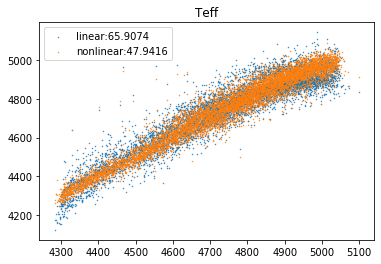

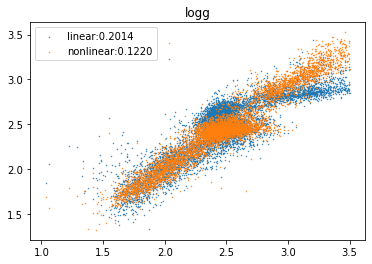

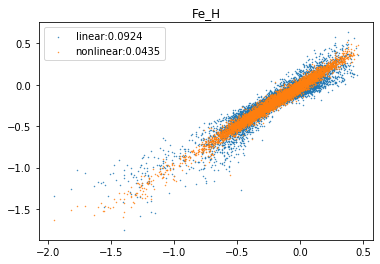

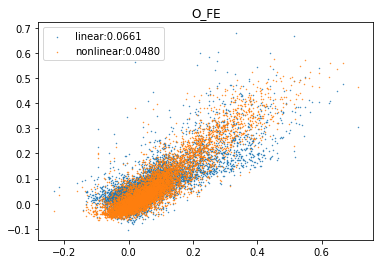

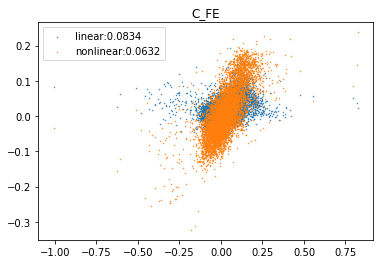

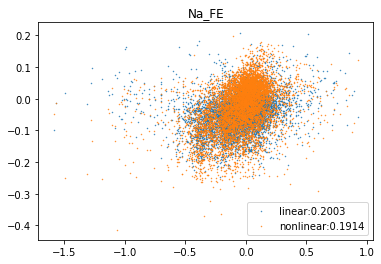

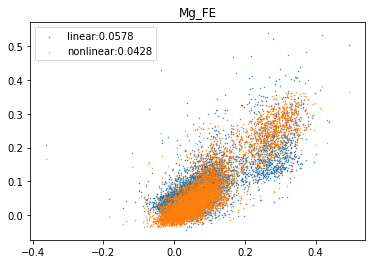

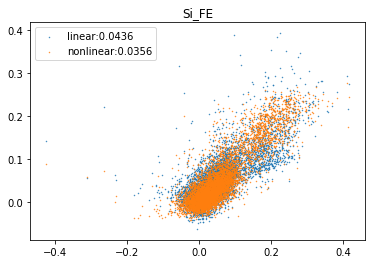

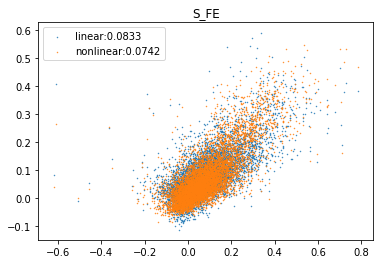

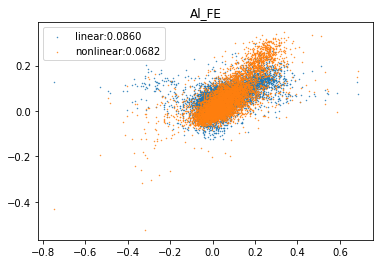

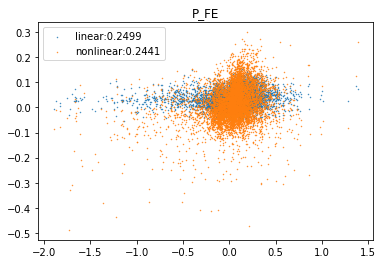

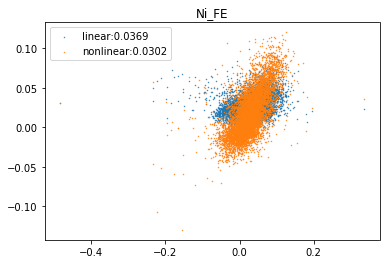

In [146]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])

    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.legend()
    plt.show()

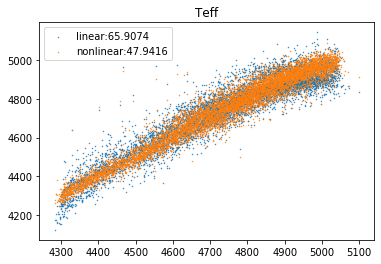

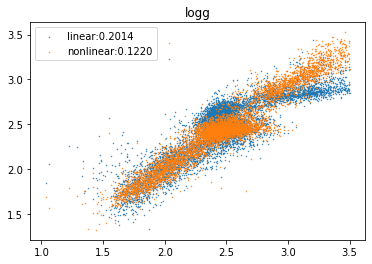

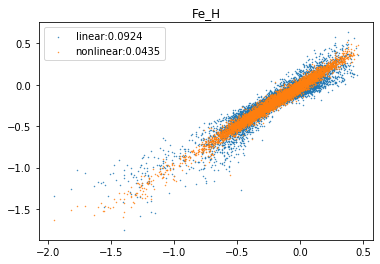

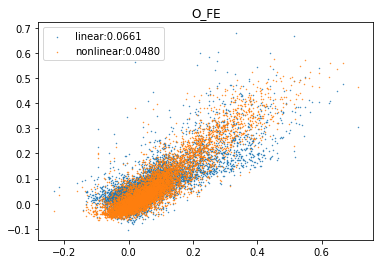

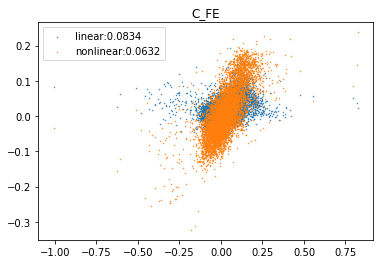

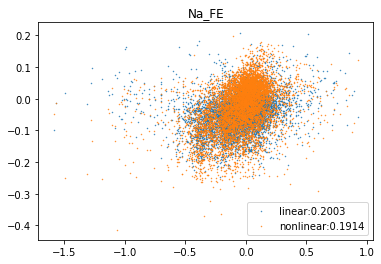

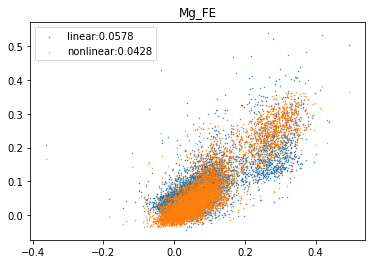

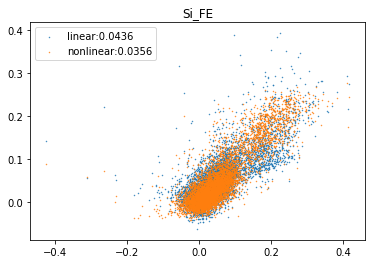

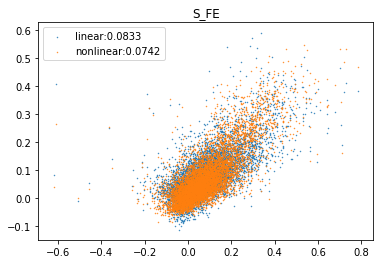

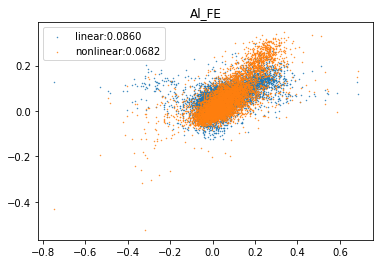

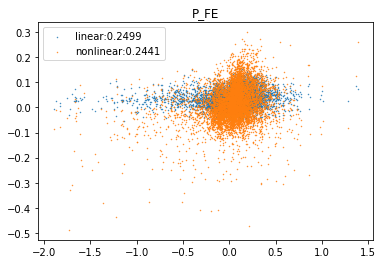

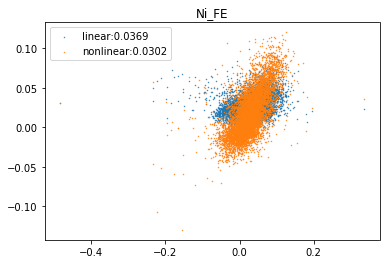

In [147]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])

    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.legend()
    plt.show()

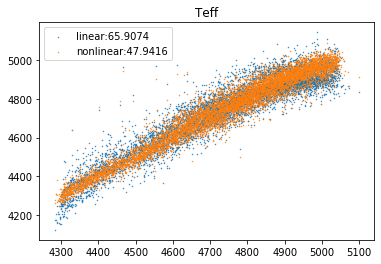

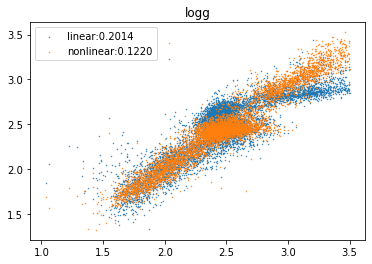

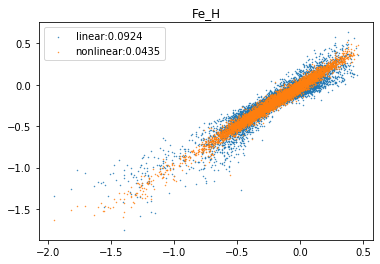

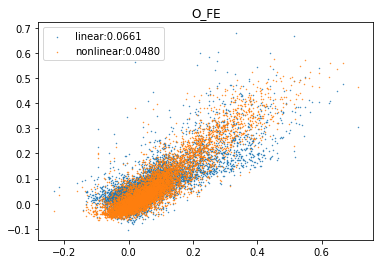

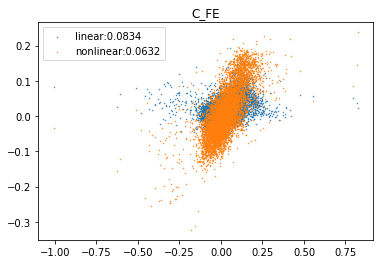

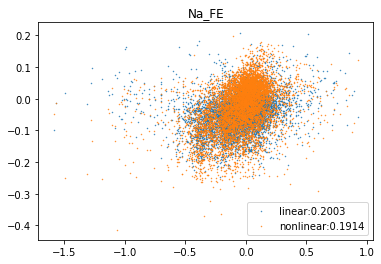

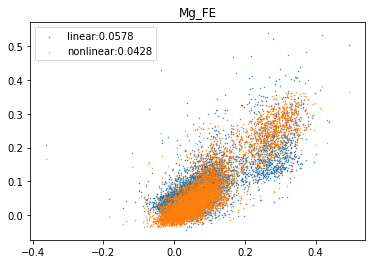

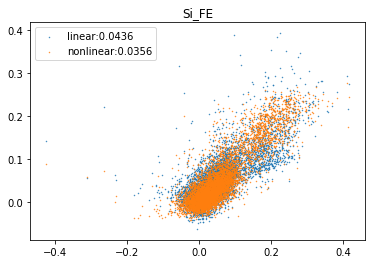

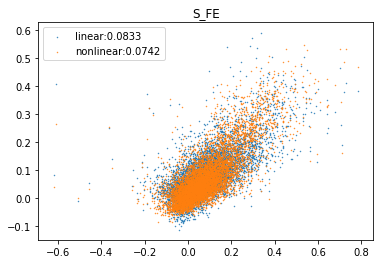

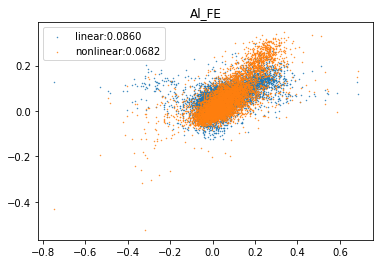

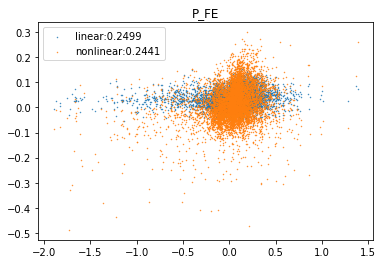

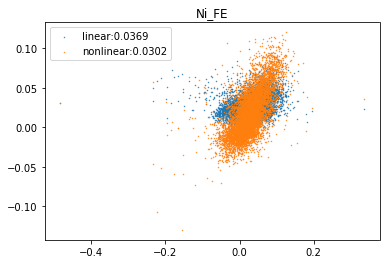

In [148]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])

    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.legend()
    plt.show()

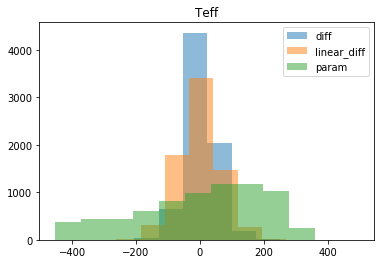

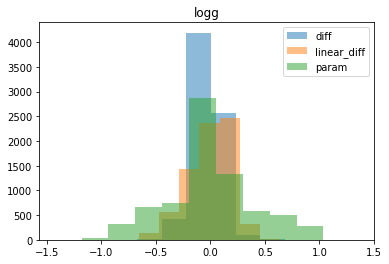

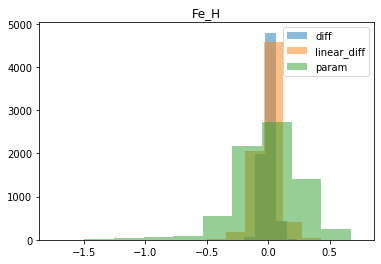

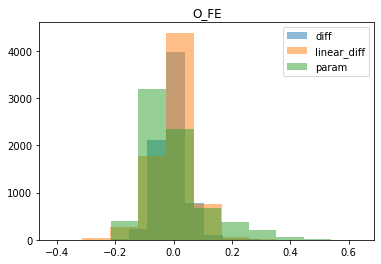

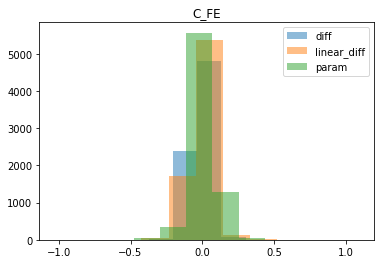

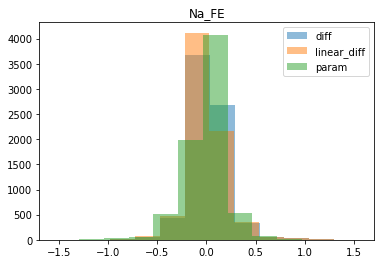

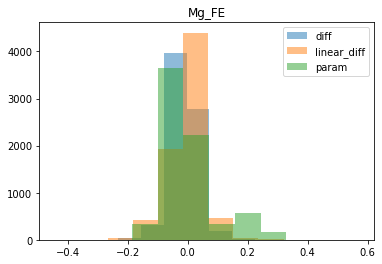

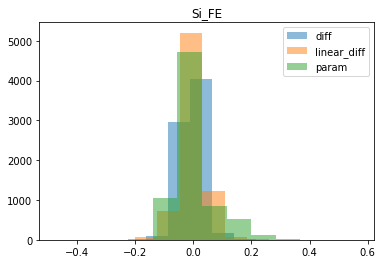

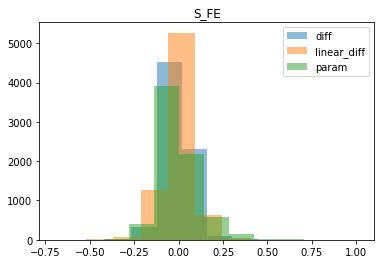

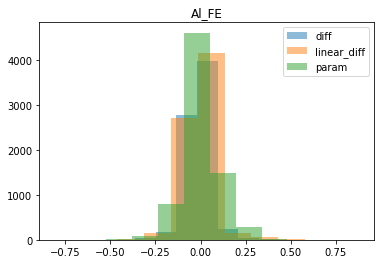

In [149]:
for i in range(10):
    plt.title(considered_parameters[i])
    plt.hist(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i],alpha=0.5,label="diff")
    plt.hist(w.predict(z).raw[:,i]-y.raw[:,i],alpha=0.5,label="linear_diff")
    plt.hist(y.raw[:,i]-np.mean(y.raw[:,i]),alpha=0.5,label="param")
    plt.legend()
    plt.show()


## Looking at Open Clusters

In [150]:
occam = load("occam")
allStar_occam = occam["allStar"]

In [151]:
dataset_occam = AspcapDataset(allStar_occam,recenter=True,tensor_type=torch.FloatTensor,filling_dataset=dataset.dataset["aspcap"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229


In [152]:
occam_cluster_idxs = occam["cluster_idxs"]
z_occam = vector.OccamLatentVector(dataset_occam,autoencoder,occam_cluster_idxs,len(dataset_occam))


occam = load("occam")
allStar_occam = occam["allStar"]
dataset_occam = ApogeeDataset(allStar_occam,outputs = ["aspcap","mask","physical","idx"])
occam_cluster_idxs = occam["cluster_idxs"]
z_occam = vector.OccamLatentVector(dataset_occam,autoencoder,occam_cluster_idxs,len(dataset_occam))


In [153]:
bad_indexes = []
for i in range(len(z_occam.raw)):
    err = np.sqrt(np.sum(((z_occam.get_x(i)-z_occam.get_x_pred(i))**2).detach().numpy()))
    print(err)
    if err>20:
        print(err)
        print(i)
        bad_indexes.append(i)
        z_occam.plot(i)
        plt.show()

/share/splinter/ddm/taggingProject/apogeeFactory/apoNN/src/vectors.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_pred,_ = self.autoencoder(torch.tensor(self.dataset[idx][0]).to(device).unsqueeze(0))


1.5505311
1.7513088
1.414628
1.289659
2.2391415
1.2082818
1.1265694
1.614523
1.50425
1.6728857
1.5739863
1.4669318
2.0742567
2.6576278
1.9182893
1.2726614
1.5816203
1.7405179
1.1349385
1.4481621
1.9010197
1.3224721
2.3257844
2.5294037
2.3950984
1.4763273
1.687036
2.749501
2.1055186
1.7023541
1.6777704
1.8207262
1.7322549
1.3224987
1.7291005
1.1855388
1.5050972
1.0424075
1.8870875
1.521225
1.1589533
1.4948578
1.6343089
1.3930808
2.0613713
2.5865512
1.6134176
1.6064972
1.2390945
1.2666826
1.6258402
1.5456674
1.6288773
1.4495245
1.4920635
1.7847613
2.1926627
2.660918
1.1754462
1.3080142
1.4018458
1.179385
1.8703759
1.624638
1.2311933
1.6821033
1.1938175
1.6431878
1.1284119
1.795313
1.4010925
1.651842
2.16612
1.5318596
1.7224922
2.0717356
1.3679848
1.1161702
2.1282282
1.6937134
1.383792
1.3334717
1.3214113
1.2661015
1.3909388
1.399793
1.8323557
1.5047439
1.4272398
1.4019426
1.3700135
1.2445313
1.8232955
1.2658019
1.0375073
1.912919
1.3255137
1.2980485
0.8713337
1.1618843
1.6352817
1.196245

In [154]:
retained= np.delete(np.arange(len(z_occam.raw)),bad_indexes)
retained

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

dataset_occam = ApogeeDataset(allStar_occam[retained],outputs = ["aspcap","mask","physical","idx"])
occam_cluster_idxs = occam["cluster_idxs"][retained]
z_occam = vector.OccamLatentVector(dataset_occam,autoencoder,occam_cluster_idxs,len(dataset_occam))


In [155]:
clust_idxs =z_occam.registry["NGC 6819"]

Text(0.5, 1.0, 'Fe_H')

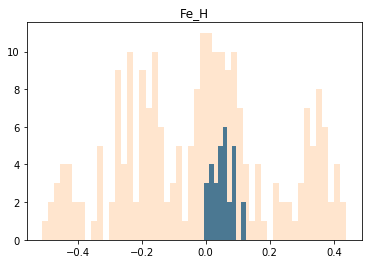

In [156]:
i=2
elem = considered_parameters[i]
plt.hist(z_occam.dataset.allStar[clust_idxs][elem],bins=9)
plt.hist(z_occam.dataset.allStar[elem],bins=50,alpha=0.2)
plt.title(elem)
#plt.xlim(-0.25,0.25)

Text(0.5, 1.0, 'Fe_H')

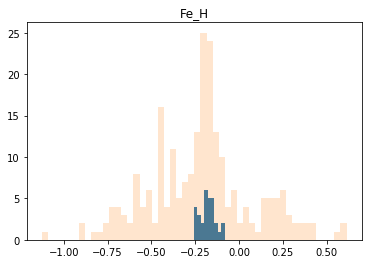

In [157]:
plt.hist(w.predict(z_occam).raw[:,i][clust_idxs],bins=9)
plt.hist(w.predict(z_occam).raw[:,i],bins=50,alpha=0.2)
#plt.hist(vector.project(z_occam.centered,w.val)[i],bins=50,alpha=0.2)

#plt.xlim(-0.25,0.25)
plt.title(considered_parameters[i])

Text(0.5, 1.0, 'Fe_H')

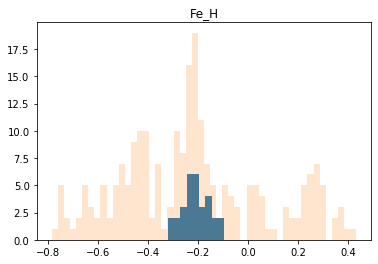

In [158]:
plt.hist(nonlinear_w.predict(z_occam).raw[:,i][clust_idxs],bins=9)
plt.hist(nonlinear_w.predict(z_occam).raw[:,i],bins=50,alpha=0.2)
#plt.hist(vector.project(z_occam.centered,w.val)[i],bins=50,alpha=0.2)

#plt.xlim(-0.25,0.25)
plt.title(considered_parameters[i])

### PCA investigation

In [159]:
whitener = PCA(n_components=8,whiten=True)


In [160]:
whitener.fit(z.centered)

ValueError: n_components=8 must be between 0 and min(n_samples, n_features)=5 with svd_solver='full'

In [ ]:
w_z_c = whitener.transform(z.centered)
w_z_occam_c = whitener.transform(z_occam.cluster_centered)

In [ ]:
pca = PCA(n_components=8)


In [ ]:
pca.fit(w_z_occam_c)


In [ ]:
pca.fit(w_z_c[:230,:])


In [ ]:
pca.fit(w_z_occam_c)

In [ ]:
w_z_occam_c.shape

In [ ]:
pca.explained_variance_

In [ ]:
pca.explained_variance_

In [ ]:
for i in range(8):
    plt.hist(z.raw[:,i],bins=100,alpha=0.2,density=True)
    plt.hist(z_occam.raw[:,i],alpha=0.5,bins=20,density=True)
    plt.show()

We can look at the variance along one direction across all clusters

In [ ]:
dim = 7
zc_b = vector.project(w_z_c,pca.components_[dim][None,:])
zoccam_b = vector.project(w_z_occam_c,pca.components_[dim][None,:])
print(f"occam:{np.var(vector.project(w_z_occam_c,pca.components_[dim][None,:]))}")
print(f"raw:{np.var(vector.project(w_z_c,pca.components_[dim][None,:]))}")

plt.hist(zoccam_b,alpha=0.2,label="diff",bins=50,density=True)
plt.hist(zc_b,alpha=0.2,label="full",bins=50, density=True)
plt.legend()

We can compare this to the raw abundances

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
considered_parameters

In [ ]:
abundances_occam = []
elem = "Fe_H"
elem_idx = considered_parameters.index(elem)

for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    abundances_occam.append(z_occam.dataset.allStar[clust_idxs][elem]-np.mean(z_occam.dataset.allStar[clust_idxs][elem]))
    #print(z_occam.dataset.allStar[clust_idxs][elem]-z_occam.dataset.allStar[clust_idxs][elem])
abundances_occam = flatten(abundances_occam)

In [ ]:
print(f"occam:{np.var(abundances_occam)}")
print(f"raw:{np.var(y.raw[:,elem_idx]-np.mean(y.raw[:,elem_idx]))}")

plt.hist(abundances_occam,alpha=0.2,label="diff",bins=50,density=True)
plt.hist(y.raw[:,elem_idx]-np.mean(y.raw[:,elem_idx]),alpha=0.2,label="full",bins=50, density=True)

### We can also compare to the astronn abundances

In [ ]:
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)
y_astronn_occam = vector.AstroNNVector(allStar_occam,considered_parameters)

In [ ]:
i=2
plt.scatter(y_astronn.raw[:,i],y.raw[:,i],s=1,alpha=0.5)
#plt.scatter(nonlinear_w.predict(z).raw[:,i],y.raw[:,i],s=0.1,alpha=0.5)
plt.xlim(-0.1,0.1)
plt.ylim(-0.1,0.1)

In [ ]:
abundances_occam = []
elem = "Fe_H"
elem_idx = considered_parameters.index(elem)

for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    abundances_occam.append(y_astronn_occam.raw[clust_idxs,elem_idx]-np.mean(y_astronn_occam.raw[clust_idxs,elem_idx]))
    #print(z_occam.dataset.allStar[clust_idxs][elem]-z_occam.dataset.allStar[clust_idxs][elem])
abundances_occam = flatten(abundances_occam)

In [ ]:
print(f"occam:{np.var(abundances_occam)}")
print(f"raw:{np.var(y_astronn.raw[:,elem_idx]-np.mean(y_astronn.raw[:,elem_idx]))}")

plt.hist(abundances_occam,alpha=0.2,label="diff",bins=50,density=True)
plt.hist(y_astronn.raw[:,elem_idx]-np.mean(y_astronn.raw[:,elem_idx]),alpha=0.2,label="full",bins=50, density=True)

In [ ]:
y_astronn_occam.raw[clust_idxs,elem_idx].shape

In [ ]:
dim = 4
zc_b = vector.project(w_z_c,pca.components_[dim][None,:])
zoccam_b = vector.project(w_z_occam_c,pca.components_[dim][None,:])
print(f"occam:{np.var(vector.project(w_z_occam_c,pca.components_[dim][None,:]))}")
print(f"raw:{np.var(vector.project(w_z_c,pca.components_[dim][None,:]))}")

plt.hist(zoccam_b,alpha=0.2,label="diff",bins=50,density=True)
plt.hist(zc_b,alpha=0.2,label="full",bins=50, density=True)
plt.legend()

How do these directions coincide with the raw abundances?

In [ ]:
w = vector.LinearTransformation(vector.Vector(w_z_c),y)


In [ ]:
import sklearn
sklearn.metrics.pairwise.cosine_similarity(pca.components_[9][None,:].reshape(1, -1),w.val[2].reshape(1, -1))

In [ ]:
allStar = allStar_behaved_restricted
idx=6
apogee_id,loc,telescope = allStar[idx]["APOGEE_ID"],allStar[idx]["FIELD"], allStar[idx]["TELESCOPE"]
spec = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=0)
spec1 = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=1)
spec2 = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=3)


In [ ]:
plt.plot(spec[0])
plt.plot(spec1[0])
plt.plot(spec2[0])
#plt.plot(spec2[0])
plt.xlim(4000,4300)

In [ ]:
allStar_behaved_restricted =  load("allStar_training_restricted")

In [ ]:
idx=6
apogee_id,loc,telescope = allStar[idx]["APOGEE_ID"],allStar[idx]["FIELD"], allStar[idx]["TELESCOPE"]
spec = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=0)
spec1 = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=1)
spec2 = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=3)

plt.plot(spec1[0])
plt.plot(dataset.dataset["aspcap"][idx])
plt.xlim(1700,1800)

In [ ]:
idx=5
apogee_id,loc,telescope = allStar[idx]["APOGEE_ID"],allStar[idx]["FIELD"], allStar[idx]["TELESCOPE"]
spec = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=1)
spec_err = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=2)
spec_fit = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=3)
plt.plot(spec[0],label="raw")
plt.plot(z.get_x_pred(idx),label="nn")
#plt.plot(z.get_x(idx),label="nn")
plt.plot(spec_fit[0],label="fit")
plt.xlim(4200,4300)
plt.legend()

In [ ]:
#plt.plot(spec_fit[0]-z.get_x_pred(idx),label="fit")
#plt.plot(spec_fit[0]-z.get_x(idx).numpy(),label="fit",alpha=0.3)
plt.plot(z.get_x_pred(idx)-z.get_x(idx).numpy(),label="nn",alpha=0.3)
plt.plot(spec_err[0],label="err",alpha=0.3)
plt.xlim(500,900)
plt.ylim(0,0.02)
plt.legend()

In [ ]:
np.var(spec_fit[0]-z.get_x(idx).numpy())

In [ ]:
np.var(z.get_x_pred(idx)-z.get_x(idx).numpy())

In [128]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=True)

In [135]:
poly.fit_transform(z.raw[:,:]).shape

(7300, 37)